# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Train/Test Split](#4.5_Train/Test_Split)
  * [4.6 Scaling data](#4.6_Scaling_data)
  * [4.7 Initial Models](#4.7_Initial_Models)
  * [4.8 Models Perfomance](#4.8_Models_Perfomance)
  * [4.9 Final Model Selection](#4.9_Final_Model_Selection)    
  * [4.10 Data quantity assessment](#4.10_Data_quantity_assessment)
  * [4.11 Save best model object](#4.11_Save_best_model_object)
  


## 4.2 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, performed preliminary assessments of data quality and refined the question to be answered. The detecting the normal ecgs was the primary aim. 

In this notebook we'll start to build machine learning models. The first model is a baseline performance comparitor for any subsequent model. Then, models are built and the process of efficiently and robustly creating and assessing models against it will be performed. 

## 4.3 Imports<a id='4.3_Imports'></a>

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

import datetime

from library.sb_utils import save_file

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [3]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features.csv')
ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


In [4]:
ecg_data.Target = ecg_data.Target.astype('int')
ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


## 4.5 Train/Test Split<a id='4.5_Train/Test_Split'></a>

In [5]:
# check if the dataset is balanced
ecg_data.Target.value_counts(normalize=True)*100

1    58.403361
0    41.596639
Name: Target, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(ecg_data.drop(columns='Target'), 
                                                    ecg_data.Target, test_size=0.2,
                                                    stratify= ecg_data.Target,random_state=47)


In [7]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((3998, 140), (3998,), (1000, 140), (1000,))

## 4.6 Scaling data<a id='4.6_Scaling_data'></a>

In [8]:
# https://towardsdatascience.com/data-leakage-in-machine-learning-6161c167e8ba
# https://stats.stackexchange.com/questions/569024/when-we-use-standardscaler-in-pipeline-with-gridsearchcv-does-it-automaticall

def scale_data(Scaler,X_train, X_test):
    sc = Scaler
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test


## 4.7 Models<a id='4.7_Models'></a>

In [9]:
# Show model's performance

def model_results(model, y_train, y_tr_pred, y_test, y_te_pred, show_training_result=True ):

    print( model)
    print('-------------------------------------')
    if show_training_result:
        print("Classification Report for Training Data")
        print(classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']))
    print('-------------------------------------')
    print("Classification Report for Test Data")
    print(classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']))


In [10]:
# Plot Model's ROC

def plot_ROC(model,X, y, title_method ):
    
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{} (area = {:2.2%})'.format(title_method,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [11]:
#  train and test a model 

def train_test_model(model, grid_params, X_train, y_train, X_test, y_test, model_name):
    pipe = make_pipeline(
    StandardScaler(),
    model
    )

    rskf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=False)
    model_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=rskf, n_jobs=-1)
    # print(model_grid_cv.get_params().keys())
    # print(model_grid_cv)
    model_grid_cv.fit(X_train, y_train)
    
    y_tr_pred = model_grid_cv.predict(X_train)
    y_te_pred = model_grid_cv.predict(X_test)
    


    if model_name in ['Random Forest', 'K_Neighbors'] :
        show_training_result = False
    else:
        show_training_result= True
    model_results(model_name, y_train, y_tr_pred, y_test, y_te_pred,show_training_result )  
    plot_ROC(model_grid_cv, X_test, y_test, model_name)

    row_model = {'model_name':model_name, 'Accuracy on training data':accuracy_score(y_tr_pred, y_train), 'Accuracy on test data':accuracy_score(y_te_pred, y_test),
'Precision score on training data':precision_score(y_train, y_tr_pred), 'Precision score  on test data':precision_score( y_test, y_te_pred), 
'Recall score on training data':recall_score(y_train, y_tr_pred), 'Recall score  on test data':recall_score( y_test, y_te_pred), 
'F1 score on training data':f1_score(y_train, y_tr_pred), 'F1 score  on test data':f1_score( y_test, y_te_pred), 
'Classification Report for Training Data':classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']), 
'Classification Report for Test Data':classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']), 
'best_params_':model_grid_cv.best_params_

    }
    return(row_model) 



c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.99      0.99      1663
      NORMAL       0.99      0.99      0.99      2335

    accuracy                           0.99      3998
   macro avg       0.99      0.99      0.99      3998
weighted avg       0.99      0.99      0.99      3998

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.98      0.98       416
      NORMAL       0.98      0.99      0.99       584

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



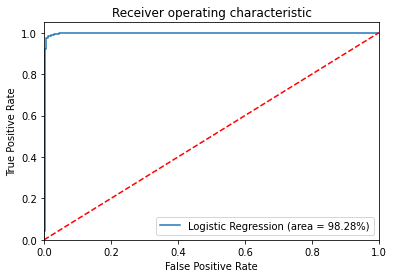

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.98      0.99       416
      NORMAL       0.99      1.00      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



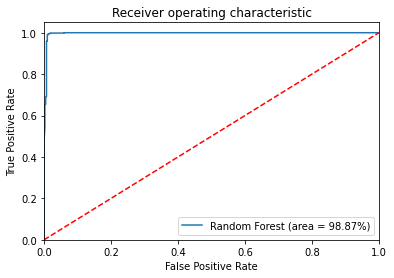

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.99      0.99      0.99       416
      NORMAL       0.99      0.99      0.99       584

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



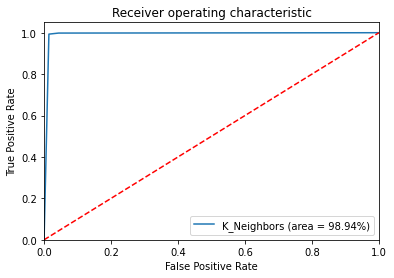

In [12]:
# define 3 models LogisticRegression, RandomForestClassifier, and KNeighborsClassifier and their parameters
params = [
    {'classifier' : [LogisticRegression(random_state=42)], 'model_name' : ['Logistic Regression'],
    'param_grid': { 'logisticregression__penalty' : ['l1', 'l2', None], 'logisticregression__C' : np.logspace(-3,3,7), 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}},
    {'classifier' : [RandomForestClassifier(random_state=42)], 'model_name' : ['Random Forest'],
    'param_grid': { 'randomforestclassifier__n_estimators' : list(range(10,100,200)), 'randomforestclassifier__max_depth' : [4,5,6,7,8], 'randomforestclassifier__criterion' :['gini', 'entropy']}}, 
    {'classifier' : [KNeighborsClassifier()], 'model_name' : ['K_Neighbors'],
    'param_grid': { 'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}}
]


# define a dataframe to save performance metrics
df_results = pd.DataFrame(columns=['model_name', 'Accuracy on training data', 'Accuracy on training data',
'Precision score on training data', 'Precision score  on test data', 
'Recall score on training data', 'Recall score  on test data', 
'F1 score on training data', 'F1 score  on test data', 
'Classification Report for Training Data', 
'Classification Report for Test Data', 
'best_params_'])

# train and test models
for model_params in params:
    model = model_params['classifier'][0]
    param_grid = model_params['param_grid']
    model_name = model_params['model_name'][0]
    result = train_test_model(model, param_grid, X_train, y_train, X_test, y_test, model_name)
    
    df_results.loc[len(df_results.index)] = result


In [13]:
df_results

,model_name,Accuracy on training data,Accuracy on training data,Precision score on training data,Precision score on test data,Recall score on training data,Recall score on test data,F1 score on training data,F1 score on test data,Classification Report for Training Data,Classification Report for Test Data,best_params_
0,Logistic Regression,0.990995,0.990995,0.991449,0.982993,0.993148,0.989726,0.992298,0.986348,precision recall f1-score ...,precision recall f1-score ...,"{'logisticregression__C': 0.1, 'logisticregres..."
1,Random Forest,0.997749,0.997749,0.997434,0.986441,0.998715,0.996575,0.998074,0.991482,precision recall f1-score ...,precision recall f1-score ...,{'randomforestclassifier__criterion': 'entropy...
2,K_Neighbors,0.996248,0.996248,1.000000,0.989761,0.993576,0.993151,0.996778,0.991453,precision recall f1-score ...,precision recall f1-score ...,"{'kneighborsclassifier__n_neighbors': 2, 'knei..."


As it can be seen the models performance might be "too good to be true". In order to investigate whether this is an artifact of of software bugs of data issues, the code was examined looking for possible bugs but not found any error. Then, some approaches were examined to discover a single leaking feature which were not successful. At the end, a subset of the features not including high correlated features is used for further analisysthe.

In [16]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features_uncorrelated85.csv')
print('\ndataset shape:', ecg_data.shape)
ecg_data.head()


dataset shape: (4998, 6)


,t0,t1,t6,t7,t139,Target
0,-0.112522,-2.827204,-2.181408,-1.818287,0.193137,1.0
1,-1.100878,-3.996840,-1.566126,-0.992258,-1.436250,1.0
2,-0.567088,-2.593450,-1.742940,-1.490658,-0.421797,1.0
3,0.490473,-1.914407,-2.993280,-1.671131,-0.383564,1.0
4,0.800232,-0.874252,-2.534510,-1.783423,1.421456,1.0


In [37]:
print('\nCorrelation between Target and other features:')
ecg_data.corr()['Target'][:].abs().T



Correlation between Target and other features:


t0        0.114752
t1        0.455028
t6        0.015209
t7        0.326290
t139      0.151506
Target    1.000000
Name: Target, dtype: float64

(3998, 5) (3998,) (1000, 5) (1000,)


c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       0.92      0.90      0.91      1663
      NORMAL       0.93      0.95      0.94      2335

    accuracy                           0.92      3998
   macro avg       0.92      0.92      0.92      3998
weighted avg       0.92      0.92      0.92      3998

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.92      0.88      0.90       416
      NORMAL       0.92      0.94      0.93       584

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.92      0.92      0.92      1000



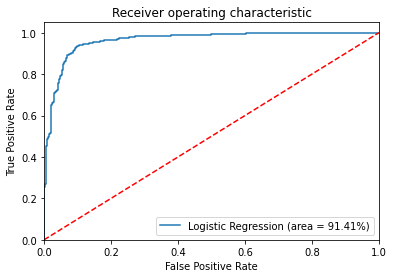

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.91      0.92       416
      NORMAL       0.94      0.96      0.95       584

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000



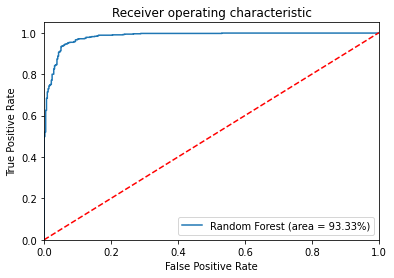

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.94      0.94       416
      NORMAL       0.96      0.95      0.95       584

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



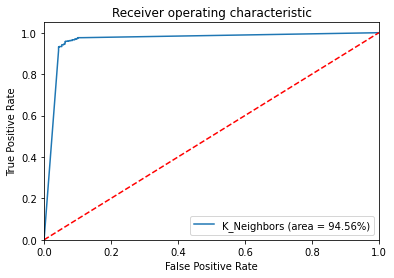

In [38]:

# X_train, X_test, y_train, y_test = train_test_split(ecg_data[['t0','t6','t139']], 
#                                                     ecg_data.Target, test_size=0.2,
#                                                     stratify= ecg_data.Target,random_state=47)

X_train, X_test, y_train, y_test = train_test_split(ecg_data[['t0', 't1',	't6',	't7',	't139']], 
                                                    ecg_data.Target, test_size=0.2,
                                                    stratify= ecg_data.Target,random_state=47)



print(X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

params = [
    {'classifier' : [LogisticRegression(random_state=42)], 'model_name' : ['Logistic Regression'],
    'param_grid': { 'logisticregression__penalty' : [ 'l2', None], 'logisticregression__C' : np.logspace(-3,3,7), 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}},
    {'classifier' : [RandomForestClassifier(random_state=42)], 'model_name' : ['Random Forest'],
    'param_grid': { 'randomforestclassifier__n_estimators' : list(range(10,100,200)), 'randomforestclassifier__max_depth' : [4,5,6,7,8], 'randomforestclassifier__criterion' :['gini', 'entropy']}}, 
    {'classifier' : [KNeighborsClassifier()], 'model_name' : ['K_Neighbors'],
    'param_grid': { 'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}}
]



# define a dataframe to save performance metrics
df_results = pd.DataFrame(columns=['model_name', 'Accuracy on training data', 'Accuracy on training data',
'Precision score on training data', 'Precision score  on test data', 
'Recall score on training data', 'Recall score  on test data', 
'F1 score on training data', 'F1 score  on test data', 
'Classification Report for Training Data', 
'Classification Report for Test Data', 
'best_params_'])

# train and test models
for model_params in params:
    model = model_params['classifier'][0]
    param_grid = model_params['param_grid']
    model_name = model_params['model_name'][0]
    result = train_test_model(model, param_grid, X_train, y_train, X_test, y_test, model_name)
    
    df_results.loc[len(df_results.index)] = result


In [39]:
df_results

,model_name,Accuracy on training data,Accuracy on training data,Precision score on training data,Precision score on test data,Recall score on training data,Recall score on test data,F1 score on training data,F1 score on test data,Classification Report for Training Data,Classification Report for Test Data,best_params_
0,Logistic Regression,0.924962,0.924962,0.927701,0.919866,0.945182,0.943493,0.93636,0.931530,precision recall f1-score ...,precision recall f1-score ...,"{'logisticregression__C': 0.1, 'logisticregres..."
1,Random Forest,0.967984,0.967984,0.970576,0.937815,0.974732,0.955479,0.97265,0.946565,precision recall f1-score ...,precision recall f1-score ...,{'randomforestclassifier__criterion': 'entropy...
2,K_Neighbors,1.000000,1.000000,1.000000,0.955403,1.000000,0.953767,1.00000,0.954584,precision recall f1-score ...,precision recall f1-score ...,"{'kneighborsclassifier__n_neighbors': 2, 'knei..."


## 4.9 Final Model Selection<a id='4.9_Final_Model_Selection'></a>

For further analisys, additional models will be built in the "Modeling" notebook and the models performance will be examined.